# Realistic fields
Look at the field from actual current loops and see if we can approximate the flat part a little better

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy.special import ellipk, ellipe
from CRESSignalStructure.QTNMTraps import BathtubTrap, HarmonicTrap
from CRESSignalStructure.Particle import Particle
from CRESSignalStructure.RealFields import BathtubField

In [2]:
# Allow LaTeX in figures
plt.rcParams['text.usetex'] = True

Plot a sample bathtub field

In [3]:
from scipy.optimize import minimize

trapDepth = 4e-3  # Tesla
rCoil = 5e-2     # metres
iCoil = 2 * trapDepth * rCoil / sc.mu_0
trapLength = 50e-2  # metres
btub = BathtubField(rCoil, iCoil, -trapLength / 2, trapLength / 2, np.array([0., 0., 1.0]))

zArr = np.linspace(-0.45 * trapLength, trapLength * 0.45, 200)
bArr = btub.evaluate_field_magnitude(0.0, 0.0, zArr)

def piecewise_quadratic(z, params):
    """
    Three-piece quadratic function: left, center, right regions.
    
    Parameters
    ----------
    z : array-like, positions
    params : array of 11 parameters
    """
    z = np.asarray(z)
    L0_edge, L1_edge, B0_centre, L0_centre = params

    B0_edge = B0_centre * (1 + L1_edge**2 / (4 * L0_centre**2))

    result = np.zeros_like(z)

    # Left region: z < -L1_edge/2
    left_mask = z < -L1_edge/2
    result[left_mask] = B0_edge * (1.0 + ((z[left_mask] + L1_edge/2) / L0_edge)**2)

    # Center region: -L1_end/2 <= z <= L1_edge/2
    centre_mask = (z >= -L1_edge/2) & (z <= L1_edge/2)
    result[centre_mask] = B0_centre * (1 + (z[centre_mask] / L0_centre)**2)
    
    # Right region: z > L1_edge/2
    right_mask = z > L1_edge/2
    result[right_mask] = B0_edge * (1.0 + ((z[right_mask] - L1_edge/2) / L0_edge)**2)
    
    return result

def fit_piecewise_quadratic(z_data, B_data, initial_params=None):
    """
    Fit symmetric piecewise quadratic function to field profile data.
    
    Parameters:
    z_data : array, axial positions
    B_data : array, magnetic field values
    initial_params : array, initial parameter guess [B0_edge, L0_edge, L1_edge, B0_centre, L0_centre]
    
    Returns:
    params : fitted parameters [B0_edge, L0_edge, L1_edge, B0_centre, L0_centre]
    z_fit : evaluation points for fitted curve
    B_fit : fitted field values
    """
    z_min, z_max = np.min(z_data), np.max(z_data)
    z_range = z_max - z_min
    B_mean = np.mean(B_data)
    
    if initial_params is None:
        # Reasonable initial guesses
        initial_params = np.array([
            z_range * 0.3,  # L0_edge
            z_range * 0.5,  # L1_edge
            B_mean,   # B0_centre (assume central dip)
            z_range * 0.2   # L0_centre
        ])

    def objective(params):
        L0_edge, L1_edge, B0_centre, L0_centre = params
        
        # Parameter bounds to ensure physical reasonableness
        if L0_edge <= 0 or L0_centre <= 0 or L1_edge <= 0:
            return 1e6
        if B0_centre <= 0:
            return 1e6
        if L1_edge >= z_range:  # Central region can't be wider than data range
            return 1e6
            
        B_pred = piecewise_quadratic(z_data, params)
        return np.sum((B_data - B_pred)**2)
    
    # Fit the model
    result = minimize(objective, initial_params, method='Nelder-Mead',
                     options={'maxiter': 10000, 'xatol': 1e-8})
    
    if not result.success:
        print(f"Warning: Optimization did not converge. Message: {result.message}")
    
    fitted_params = result.x
    
    # Generate smooth curve for plotting
    z_fit = np.linspace(z_min, z_max, 1000)
    B_fit = piecewise_quadratic(z_fit, fitted_params)
    
    return fitted_params, z_fit, B_fit

def piecewise_bathtub(z, params):
    """
    Two quadratic functions separated by a flat section 

    Parameters
    ----------
    z : array-like, positions
    params : array of 11 parameters
    """
    z = np.asarray(z)
    L0, L1, B0 = params

    result = np.zeros_like(z)

    left_mask = z < -L1/2
    result[left_mask] = B0 * (1.0 + ((z[left_mask] + L1/2) / L0)**2)

    centre_mask = (z >= -L1/2) & (z <= L1/2)
    result[centre_mask] = B0

    right_mask = z > L1/2
    result[right_mask] = B0 * (1.0 + ((z[right_mask] - L1/2) / L0)**2)

    return result

def fit_piecewise_bathtub(z_data, B_data, initial_params=None):
    """
    Fit symmetric piecewise bathtub function to field profile data.
    
    Parameters:
    z_data : array, axial positions
    B_data : array, magnetic field values
    initial_params : array, initial parameter guess [B0_edge, L0_edge, L1_edge, B0_centre, L0_centre]
    
    Returns:
    params : fitted parameters [B0_edge, L0_edge, L1_edge, B0_centre, L0_centre]
    z_fit : evaluation points for fitted curve
    B_fit : fitted field values
    """
    z_min, z_max = np.min(z_data), np.max(z_data)
    z_range = z_max - z_min
    B_mean = np.mean(B_data)
    
    if initial_params is None:
        # Reasonable initial guesses
        initial_params = np.array([
            z_range * 0.3,  # L0_edge
            z_range * 0.5,  # L1_edge
            B_mean,   # B0_centre (assume central dip)
            z_range * 0.2   # L0_centre
        ])
    
    def objective(params):
        L0, L1, B0 = params
        
        # Parameter bounds to ensure physical reasonableness
        if L0 <= 0 or L1 <= 0:
            return 1e6
        if B0 <= 0:
            return 1e6
        if L1 >= 0.999 * z_range:  # Central region can't be wider than data range
            return 1e6
            
        B_pred = piecewise_bathtub(z_data, params)
        return np.sum((B_data - B_pred)**2)
    
    # Fit the model
    result = minimize(objective, initial_params, method='Nelder-Mead',
                     options={'maxiter': 10000, 'xatol': 1e-8})
    
    if not result.success:
        print(f"Warning: Optimization did not converge. Message: {result.message}")
    
    fitted_params = result.x
    
    # Generate smooth curve for plotting
    z_fit = np.linspace(z_min, z_max, 1000)
    B_fit = piecewise_bathtub(z_fit, fitted_params)
    
    return fitted_params, z_fit, B_fit

def piecewise_quadratic_modified_continuous(z, params):
    """
    Modified three-piece function with enforced gradient continuity.
    Uses linear terms to ensure smooth transitions.
    
    Parameters
    ----------
    z : array-like, positions
    params : array of 4 parameters [L0_edge, L1_edge, B0_centre, L0_centre]
    """
    z = np.asarray(z)
    L0_edge, L1_edge, B0_centre, L0_centre = params
    
    # Calculate gradients and values at boundaries for continuity
    boundary = L1_edge / 2
    
    # Value at boundary from center piece
    B_boundary = B0_centre * (1 + (boundary / L0_centre)**2)
    
    # Gradient at boundary from center piece  
    grad_boundary = B0_centre * 2 * boundary / (L0_centre**2)
    
    result = np.zeros_like(z)
    
    # Left region: z < -boundary
    left_mask = z < -boundary
    # Use form: B0_edge + a*(z+boundary)^2 + b*(z+boundary)
    # Continuity: B0_edge = B_boundary, b = -grad_boundary
    z_left = z[left_mask] + boundary
    result[left_mask] = B_boundary - grad_boundary * z_left + (z_left / L0_edge)**2
    
    # Center region: -boundary <= z <= boundary
    centre_mask = (z >= -boundary) & (z <= boundary)
    result[centre_mask] = B0_centre * (1 + (z[centre_mask] / L0_centre)**2)
    
    # Right region: z > boundary
    right_mask = z > boundary
    # Use form: B0_edge + a*(z-boundary)^2 + b*(z-boundary) 
    # Continuity: B0_edge = B_boundary, b = grad_boundary
    z_right = z[right_mask] - boundary
    result[right_mask] = B_boundary + grad_boundary * z_right + (z_right / L0_edge)**2
    
    return result

def fit_piecewise_quadratic_modified_continuous(z_data, B_data, initial_params=None):
    """
    Fit symmetric piecewise quadratic function to field profile data.
    
    Parameters:
    z_data : array, axial positions
    B_data : array, magnetic field values
    initial_params : array, initial parameter guess [B0_edge, L0_edge, L1_edge, B0_centre, L0_centre]
    
    Returns:
    params : fitted parameters [B0_edge, L0_edge, L1_edge, B0_centre, L0_centre]
    z_fit : evaluation points for fitted curve
    B_fit : fitted field values
    """
    z_min, z_max = np.min(z_data), np.max(z_data)
    z_range = z_max - z_min
    B_mean = np.mean(B_data)
    
    if initial_params is None:
        # Reasonable initial guesses
        initial_params = np.array([
            z_range * 0.3,  # L0_edge
            z_range * 0.5,  # L1_edge
            B_mean,   # B0_centre (assume central dip)
            z_range * 0.2   # L0_centre
        ])

    def objective(params):
        L0_edge, L1_edge, B0_centre, L0_centre = params
        
        # Parameter bounds to ensure physical reasonableness
        if L0_edge <= 0 or L0_centre <= 0 or L1_edge <= 0:
            return 1e6
        if B0_centre <= 0:
            return 1e6
        if L1_edge >= z_range:  # Central region can't be wider than data range
            return 1e6
            
        B_pred = piecewise_quadratic_modified_continuous(z_data, params)
        return np.sum((B_data - B_pred)**2)
    
    # Fit the model
    result = minimize(objective, initial_params, method='Nelder-Mead',
                     options={'maxiter': 10000, 'xatol': 1e-8})
    
    if not result.success:
        print(f"Warning: Optimization did not converge. Message: {result.message}")
    
    fitted_params = result.x
    
    # Generate smooth curve for plotting
    z_fit = np.linspace(z_min, z_max, 1000)
    B_fit = piecewise_quadratic_modified_continuous(z_fit, fitted_params)
    
    return fitted_params, z_fit, B_fit

Fit parameters (quadratic): L0_edge = 1.568e+00, L1 = 2.942e-01, B0_centre = 1.000e+00, L0_centre = 8.539e+00
Fit parameters (bathtub): L0 = 1.887e+00, L1 = 2.589e-01, B0 = 1.000e+00


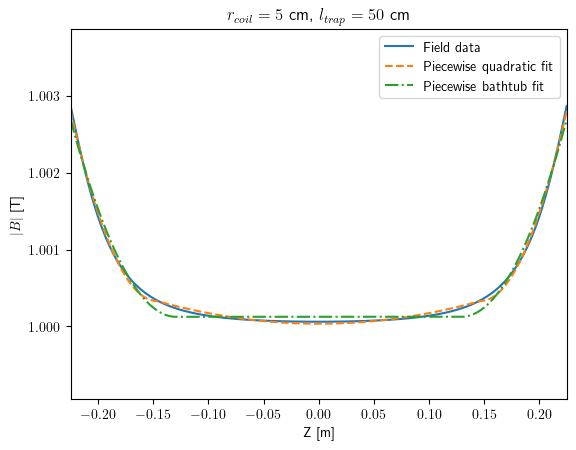

In [4]:
B_mean = np.mean(bArr)
z_range = zArr[-1] - zArr[0]

# Fit the quadratic function
initialParams = np.array([1.0, z_range * 0.5, B_mean*0.999, 5.0])    
initialBAttempt = piecewise_quadratic(zArr, initialParams)
fitted_params, z_fit, B_fit = fit_piecewise_quadratic(zArr, bArr, 
                                                      initial_params=initialParams)
L0_edge_fit = fitted_params[0]
L1_fit = fitted_params[1]
B0_c_fit = fitted_params[2]
L0_c_fit = fitted_params[3]
print(f"Fit parameters (quadratic): L0_edge = {L0_edge_fit:.3e}, L1 = {L1_fit:.3e}, "
      f"B0_centre = {B0_c_fit:.3e}, L0_centre = {L0_c_fit:.3e}")

# Fit the modified quadratic function
fitted_params2, _, B_fit2 = fit_piecewise_quadratic(zArr, bArr, initial_params=initialParams)

# Now fit the flat bathtub
initialParams = np.array([1.0, z_range * 0.5, B_mean*0.999])
fitted_params_btub, _, B_fit_btub = fit_piecewise_bathtub(zArr, bArr, initial_params=initialParams)
print(f"Fit parameters (bathtub): L0 = {fitted_params_btub[0]:.3e}, L1 = {fitted_params_btub[1]:.3e}, "
      f"B0 = {fitted_params_btub[2]:.3e}")

fig, ax = plt.subplots(1,1)
ax.plot(zArr, bArr, label='Field data')
#ax.plot(zArr, initialBAttempt, 'r--', label='Initial prediction')
ax.plot(z_fit, B_fit, '--', label='Piecewise quadratic fit')
#ax.plot(z_fit, B_fit2, '-.', label='Piecewise modified quadratic fit')
ax.plot(z_fit, B_fit_btub, '-.', label='Piecewise bathtub fit')
ax.set_xlabel("Z [m]")
ax.set_ylabel("$|B|$ [T]")
ax.set_ylim(0.999 * np.min(bArr), 1.001 * np.max(bArr))
ax.set_xlim(np.min(zArr),np.max(zArr))
#ax.axvline(-fitted_params[1]/2, linestyle='--')
#ax.axvline(fitted_params[1]/2, linestyle='--')
ax.set_title(r'$r_{coil} = 5$ cm, $l_{trap} = 50$ cm')
ax.legend()

Define a function for calculating the axial frequency for the 3 quadratic case.

In [ ]:
def CalcOmegaAxPiecewise(B0c, L0c, L1, L0e, v, pa):
    """
    Calculate the angular axial frequency for the piecewise case
    """
    # Define conditions for which solution to use
    htrap = HarmonicTrap(B0c, L0c)
    zMaxCentre = htrap.CalcZMax(pa)
    B0e = B0c * (1 + L1**2 / (4 * L0c**2))

    conditions = [zMaxCentre > L1/2, zMaxCentre <= L1/2]
    thetaBot2 = np.asin(np.sqrt(1 + L1**2 / (4 * L0c**2)) * np.sin(pa))
    t1 = L0c * np.asin(L1 * np.tan(pa) / (2 * L0c)) / (v * np.sin(pa))
    t21 = np.pi * L0_edge_fit / (2 * v * np.sin(thetaBot2))
    choices = [(2 * (t1 + t21) / np.pi)**(-1), htrap.CalcOmegaAxial(v, pa)]
    return np.select(conditions, choices)

Use the fitted parameters for a comparison of the analytical bathtub with the piecewise quadratic. 

89.01303874839526
89.01303874839526


/tmp/ipykernel_78933/2209875951.py:9: RuntimeWarning: invalid value encountered in arcsin
  t1_choices = [np.pi * L0_c_fit / (2 * v * np.sin(pa)), L0_c_fit * np.asin(L1_fit * np.tan(pa) / (2 * L0_c_fit)) / (v * np.sin(pa))]


(86.5, 89.13869068581502)

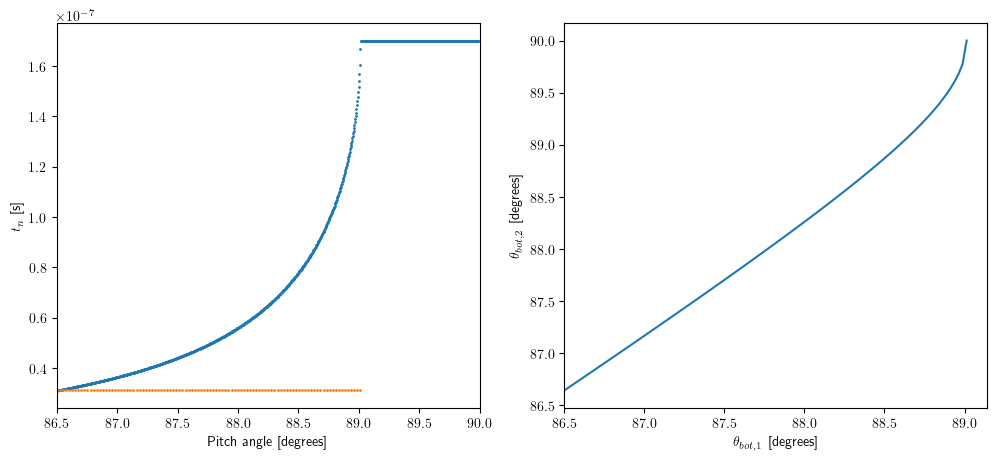

In [6]:
thetaMin = np.atan(2 * L0_c_fit / L1_fit)
print(thetaMin * 180 / np.pi)
htrap = HarmonicTrap(B0_c_fit, L0_c_fit)
pa = np.linspace(86.5 * np.pi / 180, 0.9999 * np.pi/2, 1000)
v = 0.263 * sc.c

zm = htrap.CalcZMax(pa)
conditions = [zm < L1_fit/2, zm >= L1_fit/2]
t1_choices = [np.pi * L0_c_fit / (2 * v * np.sin(pa)), L0_c_fit * np.asin(L1_fit * np.tan(pa) / (2 * L0_c_fit)) / (v * np.sin(pa))] 

paEscape = np.linspace(86.5 * np.pi / 180, thetaMin, 100)
print(np.max(paEscape) * 180 / np.pi)

t1 = np.select(conditions, t1_choices)
thetaBot2 = np.asin(np.sqrt(1 + L1_fit**2 / (4 * L0_c_fit**2)) * np.sin(paEscape))
B0e = B0_c_fit * (1 + L1_fit**2 / (4 * L0_c_fit**2))
t21 = np.pi * L0_edge_fit / (2 * v * np.sin(thetaBot2))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(pa * 180 / np.pi, t1, 'o', label=r'$t_1$', markersize=1)
ax[0].plot(paEscape * 180 / np.pi, t21, 'o', label=r'$t_{2,1}$', markersize=1)
ax[0].set_xlabel('Pitch angle [degrees]')
ax[0].set_ylabel(r'$t_n$ [s]')
ax[0].set_xlim(86.5, 90.0)

ax[1].plot(paEscape * 180 / np.pi, thetaBot2 * 180 / np.pi)
ax[1].set_xlabel(r'$\theta_{bot,1}$ [degrees]')
ax[1].set_ylabel(r'$\theta_{bot,2}$ [degrees]')
ax[1].set_xlim(86.5, None)

We can also do the integration of the trap numerically and avoid having to stitch functions together. To find the electron position at a given time we use
$$
t = \int^{z_0(t)}_{z_0(0)} \frac{dz'}{\sqrt{\frac{2}{m} (K_e - \mu B(z')) }} \, ,
$$
while for symmetric traps we can calculate the axial frequency of the electron using
$$
\Omega_a^{-1} = \frac{2}{\pi} \int_0^{z_{max}} \frac{dz}{\sqrt{\frac{2}{m}(E_0 - \mu B(z))}} \, .
$$

In [7]:
from CRESSignalStructure.NumericalSpectrumCalculator import calc_omega_axial, calc_zmax

testParticle = Particle(18.6e3, np.zeros(3), 88.5 * np.pi / 180)
oa = calc_omega_axial(btub, testParticle)
zmax = calc_zmax(btub, testParticle) 
print(f"Axial frequency = {oa/ (2 * np.pi) / 1e6:.1f} MHz, z_max = {zmax * 1e2:.1f} cm")

Axial frequency = 2.4 MHz, z_max = 17.8 cm


/tmp/ipykernel_78933/810505044.py:11: RuntimeWarning: invalid value encountered in arcsin
  thetaBot2 = np.asin(np.sqrt(1 + L1**2 / (4 * L0c**2)) * np.sin(pa))
/tmp/ipykernel_78933/810505044.py:12: RuntimeWarning: invalid value encountered in arcsin
  t1 = L0c * np.asin(L1 * np.tan(pa) / (2 * L0c)) / (v * np.sin(pa))


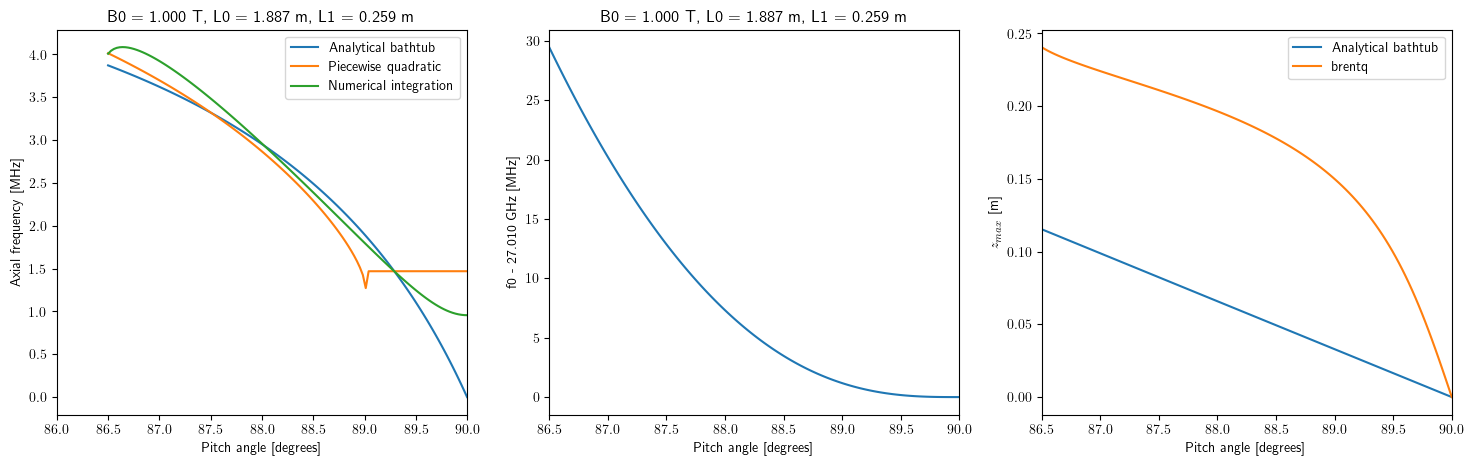

In [ ]:
bathtubAna = BathtubTrap(fitted_params_btub[2], fitted_params_btub[0], fitted_params_btub[1])
pitchAngleArray = np.linspace(86.5, 89.9999, 125) * np.pi / 180
axialFreqArray = bathtubAna.CalcOmegaAxial(0.263 * sc.c, pitchAngleArray) / (2 * np.pi)
axFreqCalc = CalcOmegaAxPiecewise(B0_c_fit, L0_c_fit, L1_fit, L0_edge_fit, 
                                  0.263 * sc.c, pitchAngleArray) / (2 * np.pi)

axialFreqsNumerical = np.zeros_like(pitchAngleArray)
zMaxBasic = np.zeros_like(pitchAngleArray)
for i, p in enumerate(pitchAngleArray):
    axialFreqsNumerical[i] = calc_omega_axial(btub, Particle(18.6e3, np.zeros(3), p))
    zMaxBasic[i] = calc_zmax(btub, Particle(18.6e3, np.zeros(3), p))

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(pitchAngleArray * 180 / np.pi, axialFreqArray / 1e6, label='Analytical bathtub')
ax[0].plot(pitchAngleArray * 180 / np.pi, axFreqCalc / 1e6, label='Piecewise quadratic')
ax[0].plot(pitchAngleArray * 180 / np.pi, axialFreqsNumerical / (2 * np.pi) / 1e6, label='Numerical integration')
ax[0].set_title(f"B0 = {fitted_params_btub[2]:.3f} T, L0 = {fitted_params_btub[0]:.3f} m, L1 = {fitted_params_btub[1]:.3f} m")
ax[0].set_xlabel("Pitch angle [degrees]")
ax[0].set_ylabel("Axial frequency [MHz]")
ax[0].set_xlim(86, 90)
ax[0].legend()

avgFreqArray = bathtubAna.CalcOmega0(0.263 * sc.c, pitchAngleArray) / (2 * np.pi)
ax[1].plot(pitchAngleArray * 180 / np.pi, (avgFreqArray - np.min(avgFreqArray)) / 1e6, label='Analytical bathtub')
ax[1].set_title(f"B0 = {fitted_params_btub[2]:.3f} T, L0 = {fitted_params_btub[0]:.3f} m, L1 = {fitted_params_btub[1]:.3f} m")
ax[1].set_xlabel("Pitch angle [degrees]")
ax[1].set_ylabel(f"f0 - {np.min(avgFreqArray) / 1e9:.3f} GHz [MHz]")
ax[1].set_xlim(86.5, 90)

ax[2].plot(pitchAngleArray * 180 / np.pi, bathtubAna.CalcZMax(pitchAngleArray),label='Analytical bathtub')
ax[2].plot(pitchAngleArray * 180 / np.pi, zMaxBasic, label='brentq')
ax[2].set_xlabel("Pitch angle [degrees]")
ax[2].set_ylabel(r"$z_{max}$ [m]")
ax[2].set_xlim(86.5, 90)
ax[2].legend()

## Calculate axial motion
The general solution for the electron's axial position is given by
$$
t = \int_{z_0(0)}^{z_0(t)} \frac{dz'}{\sqrt{\frac{2}{m} (K_e - \mu B(z'))}} \, .
$$

From symmetry arguments we actually only need to calculate one part of the motion before applying some flips to get the whole thing.

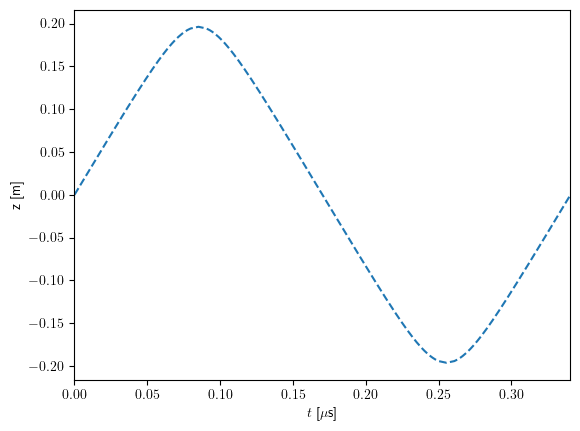

In [9]:
from CRESSignalStructure.NumericalSpectrumCalculator import calc_t_vs_z

pitchAngle = 88.0 * np.pi / 180
t, z = calc_t_vs_z(btub, Particle(18.6e3, np.zeros(3), pitchAngle))

plt.figure()
plt.plot(t * 1e6, z, '--')
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"z [m]")
plt.xlim(0.0, t[-1] * 1e6)
plt.show()

## Phase, $\Phi(t)$
Now that we have this function, we can use interpolation to obtain the relationship $B(t)$.

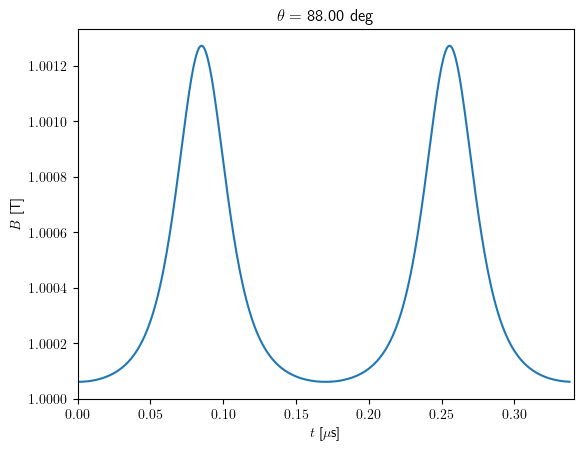

In [10]:
from CRESSignalStructure.NumericalSpectrumCalculator import B_from_t

p1 = Particle(18.6e3, np.zeros(3), pitchAngle)

# Calculate the period of the axial motion
oa = calc_omega_axial(btub, p1)

t_vals, B = B_from_t(btub, p1, 499)
plt.figure()
plt.plot(t_vals * 1e6, B)
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"$B$ [T]")
plt.title(fr"$\theta =$ {pitchAngle * 180 / np.pi:.2f} deg")
plt.xlim(0.0, t[-1] * 1e6)
plt.ylim(1.0, None)
plt.show()

The cyclotron phase is found to be
$$
\Phi_c(t) = \int_0^t \frac{e B(t')}{\gamma m_e} dt' \, \,
$$
which can be determined from the above plot.

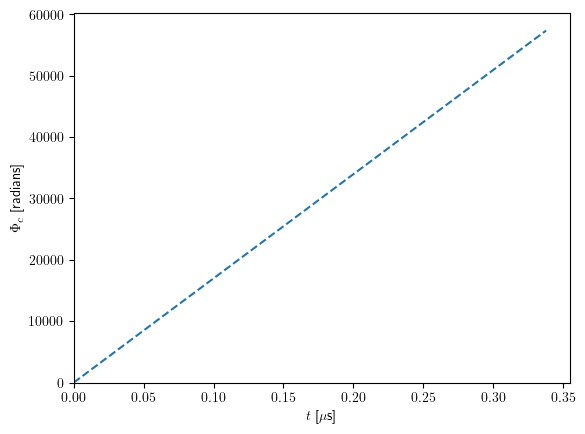

f0 = 27.020 GHz


In [11]:
from CRESSignalStructure.NumericalSpectrumCalculator import cyclotron_phase_from_t, calc_omega_0

t_vals, phiTest = cyclotron_phase_from_t(btub, p1, 499)
plt.figure()
plt.plot(t_vals * 1e6, phiTest, '--')
plt.xlabel(r"$t$ [$\mu$s]")
plt.ylabel(r"$\Phi_c$ [radians]")
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

print(f"f0 = {calc_omega_0(btub, p1, 499) / 1e9 / (2 * np.pi):.3f} GHz")

Check how these numerical calculations for the average frequencies compare with the results from the analytical bathtub.

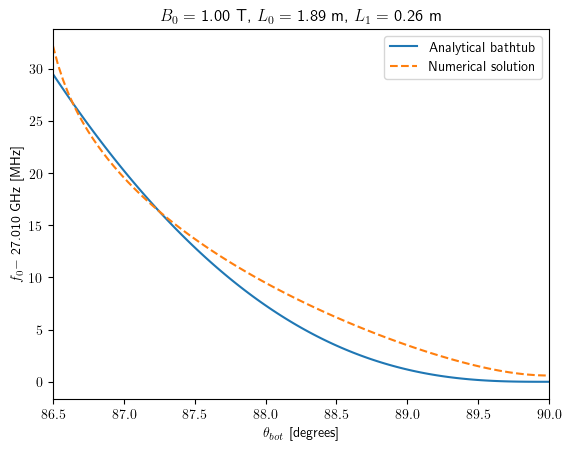

In [12]:
testNumericalPitches = np.linspace(86.5, 89.999, 100) * np.pi / 180
avgFreqsNumerical = np.zeros_like(testNumericalPitches)
for i, testPitch in enumerate(testNumericalPitches):
    testParticle = Particle(18.6e3, np.zeros(3), testPitch)
    # Calculate the axial frequency for the time binning
    oa = calc_omega_axial(btub, testParticle)
    Ta = 1.0 / (oa / (2 * np.pi))
    avgFreqsNumerical[i] = calc_omega_0(btub, testParticle, 499) / (2 * np.pi)

plt.figure()
plt.plot(pitchAngleArray * 180 / np.pi, (avgFreqArray - np.min(avgFreqArray)) / 1e6, label='Analytical bathtub')
plt.plot(testNumericalPitches * 180 / np.pi, (avgFreqsNumerical - np.min(avgFreqArray)) / 1e6,
         '--', label='Numerical solution')
plt.title(fr"$B_0 =$ {fitted_params_btub[2]:.2f} T, $L_0 =$ {fitted_params_btub[0]:.2f} m, $L_1 =$ {fitted_params_btub[1]:.2f} m")
plt.xlabel(r"$\theta_{bot}$ [degrees]")
plt.ylabel(fr"$f_0 -$ {np.min(avgFreqArray) / 1e9:.3f} GHz [MHz]")
plt.xlim(86.5, 90)
plt.legend()
plt.show()

## Peak magnitudes
We can now find the Fourier coefficients using the following formula:
$$
a_n = \frac{1}{T_a} \int_0^{T_a} e^{i(\Phi_c(t) + \beta z(t))} e^{-i(\Omega_a + n \Omega_a)t} \, dt \, ,
$$
where $\beta$ is the propagation constant.

In [13]:
from CRESSignalStructure.NumericalSpectrumCalculator import NumericalSpectrumCalculator
from CRESSignalStructure.CircularWaveguide import CircularWaveguide

wgR = 5e-3
wg = CircularWaveguide(wgR)
spec = NumericalSpectrumCalculator(btub, wg, Particle(18.6e3, np.zeros(3), 89.995*np.pi/180), )
print(np.abs(spec.GetPeakAmp(0))**2)

[0.87336765]
